# Subjectivity in News Articles

## Group:
- Luca Babboni - luca.babboni2@studio.unibo.it
- Matteo Fasulo - matteo.fasulo@studio.unibo.it
- Luca Tedeschini - luca.tedeschini3@studio.unibo.it

## Description

This notebook addresses Task 1 proposed in [CheckThat Lab](https://checkthat.gitlab.io/clef2025/) of CLEF 2025. In this task, systems are challenged to distinguish whether a sentence from a news article expresses the subjective view of the author behind it or presents an objective view on the covered topic instead.

This is a binary classification tasks in which systems have to identify whether a text sequence (a sentence or a paragraph) is subjective (SUBJ) or objective (OBJ).

The task comprises three settings:

* Monolingual: train and test on data in a given language
* Multilingual: train and test on data comprising several languages
* Zero-shot: train on several languages and test on unseen languages

training data in five languages:
* Arabic
* Bulgarian
* English
* German
* Italian

The official evaluation is macro-averaged F1 between the two classes.

# Installing dependencies

This notebook uses quantized models, and some additional libraries are required. If you are running this notebook on either Colab or Kaggle, please run the cell below once, then run the whole notebook normally.



In [ ]:
%%capture
%pip install -U transformers[torch] bitsandbytes trl peft sacremoses ctranslate2 accelerate

In [ ]:
import os
os.kill(os.getpid(), 9)

## Importing libraries

In [147]:
import os
import gc
from pathlib import Path

import csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F

from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from datasets import Dataset
from huggingface_hub import notebook_login
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments, 
    DataCollatorWithPadding, 
    BitsAndBytesConfig,
    PreTrainedModel,
    ModernBertPreTrainedModel,
    DebertaV2Model, 
    ModernBertModel,
    DebertaV2Config,
    ModernBertConfig,
    pipeline
)
from transformers.trainer_utils import PredictionOutput
from transformers.models.deberta.modeling_deberta import ContextPooler
from transformers.models.modernbert.modeling_modernbert import ModernBertPredictionHead
from transformers.activations import GELUActivation

## Setting the device

In [2]:
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tqdm.pandas() # display tqdm on pandas apply functions
print(f"Using device: {device}")

Using device: cuda


## Setting Library Seeds

This step is necessary to guarantee reproducibility.



In [3]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

## Setting the Data Folder  

Please modify this path with your dataset's local path. The `data` folder should follow the official challenge structure:
```
data/
|---- arabic/
|--------- xxxx.tsv
|---- bulgarian/
|--------- xxxx.tsv
|---- english/
|--------- xxxx.tsv
|---- german/
|--------- xxxx.tsv
|---- italian/
|--------- xxxx.tsv
```

In [4]:
data_folder = '/kaggle/input/clef2025-checkthat/data' # data

## Hugging face notebook login

To correctly download and use the hugging face models, a token key needs to be provided. Please refer to this [page](https://huggingface.co/docs/hub/security-tokens)

In [5]:
notebook_login()

# Subjectivity Class  
This class is used throughout the whole notebook as a utility toolbox to avoid code redundancy. When a method of this class is called for the first time, its behavior will be explained.  

In [6]:
class Subjectivity:
    """
    A class for handling multilingual subjectivity classification datasets.
    
    This class provides functionality to load, process, and prepare datasets for 
    subjective/objective text classification across multiple languages. It supports:
    - Loading and organizing datasets from multiple languages
    - Splitting data into train/dev/test sets
    - Analyzing label distributions
    - Loading pre-trained tokenizers and models
    - Computing class weights for imbalanced datasets
    
    Attributes:
        seed (int): Random seed for reproducibility
        device (str): Computation device ('cuda' or 'cpu')
        languages (list): List of available languages in the dataset
        dataset (pd.DataFrame): Combined dataset with all languages and splits
        train (pd.DataFrame): Training split of the dataset
        dev (pd.DataFrame): Development split of the dataset
        test (pd.DataFrame): Test split of the dataset
        all_data (dict): Nested dictionary organizing data by language and split
        tokenizer (AutoTokenizer, optional): Hugging Face tokenizer
        model (AutoModelForSequenceClassification, optional): Classification model
    """
    def __init__(self, data_folder: str = 'data', seed: int = 42, device: str = 'cuda'):
        """
        Initialize the Subjectivity class.
        
        Args:
            data_folder (str): Directory path containing the dataset files.
            seed (int): Random seed for reproducibility.
            device (str): Device to use for computations ('cuda' or 'cpu').
        """
        self.seed = seed
        self.device = device
        self.languages = [language for language in os.listdir(data_folder)]

        dataset = self.create_dataset(data_folder=data_folder)
        self.dataset = dataset
        
        train, dev, test = self.get_splits(dataset, print_shapes=True)
        self.train = train
        self.dev = dev
        self.test = test

        self.all_data = self.get_per_lang_dataset()
        

    def create_dataset(self, data_folder: str = 'data'):
        """
        Create a consolidated dataset from files in multiple languages.
        
        Args:
            data_folder (str): Directory path containing subdirectories for each language.
            
        Returns:
            pd.DataFrame: Combined dataset with columns for sentence_id, sentence, label, 
                          language, and split information.
        """
        dataset = pd.DataFrame(columns=['sentence_id','sentence','label','lang','split'])
        for language in os.listdir(data_folder):
            for filename in os.listdir(f"{data_folder}{os.sep}{language}"):
                if '.tsv' in filename:
                    abs_path = f"{data_folder}{os.sep}{language}{os.sep}{filename}"
                    df = pd.read_csv(abs_path, sep='\t', quoting=csv.QUOTE_NONE)
                    if 'solved_conflict' in df.columns:
                        df.drop(columns=['solved_conflict'], inplace=True)
                    df['lang'] = language
                    df['split'] = Path(filename).stem
                    dataset = pd.concat([dataset, df], axis=0)
        return dataset

    def get_splits(self, dataset: pd.DataFrame, print_shapes: bool = True):
        """
        Split the dataset into training, development, and test sets.
        
        Args:
            dataset (pd.DataFrame): The combined dataset to split.
            print_shapes (bool): Whether to print the shapes of the resulting splits.
            
        Returns:
            tuple: A tuple containing three pandas DataFrames (train, dev, test).
        """
        train = dataset[dataset['split'].str.contains('train')].copy()
        dev = dataset[(dataset['split'].str.contains('dev')) & ~(dataset['split'].str.contains('dev_test'))].copy()
        test = dataset[dataset['split'].str.contains('dev_test')].copy()

        # encode the target variable to int (0: obj; 1: subj)
        train.loc[:, 'label'] = train['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
        dev.loc[:, 'label'] = dev['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
        test.loc[:, 'label'] = test['label'].apply(lambda x: 0 if x == 'OBJ' else 1)

        # cast to int
        train['label'] = train['label'].astype(int)
        dev['label'] = dev['label'].astype(int)
        test['label'] = test['label'].astype(int)

        if print_shapes:
            print(f"Train: {train.shape}")
            print(f"Dev: {dev.shape}")
            print(f"Test: {test.shape}")
            
        return train, dev, test

    def get_per_lang_dataset(self):
        """
        Organize the dataset by language and split (train, dev, test).
        
        Returns:
            dict: A nested dictionary with languages as the outer keys and
                  split names ('train', 'dev', 'test') as inner keys.
                  For example:
                  {
                      'english': {
                          'train': pd.DataFrame,
                          'dev': pd.DataFrame,
                          'test': pd.DataFrame
                      },
                      ...
                  }
        """
        dataset_dict = {}
        for language in self.languages:
            dataset_dict[language] = {}
            # get the train data
            dataset_dict[language]['train'] = self.train[self.train['lang']==language].copy()
            # get the dev data
            dataset_dict[language]['dev'] = self.dev[self.dev['lang']==language].copy()
            # get the test data
            dataset_dict[language]['test'] = self.test[self.test['lang']==language].copy()
        return dataset_dict

    def print_label_distrib(self, dataset: pd.DataFrame):
        """
        Print the normalized distribution of labels in the dataset.
        
        Args:
            dataset (pd.DataFrame): The dataset containing a 'label' column.
            
        Returns:
            None: Prints the percentage distribution of each label.
        """
        print(dataset['label'].value_counts(normalize=True))

    def get_tokenizer(self, model_card: str = "microsoft/mdeberta-v3-base"):
        """
        Load a tokenizer from the Hugging Face model hub.
        
        Args:
            model_card (str): Identifier for the pre-trained tokenizer to load.
            
        Returns:
            AutoTokenizer: The loaded tokenizer.
        """
        tokenizer = AutoTokenizer.from_pretrained(model_card)
        self.tokenizer = tokenizer
        return tokenizer

    def get_model(self, model_card: str = "microsoft/mdeberta-v3-base", *args, **kwargs):
        """
        Load a pre-trained model from the Hugging Face model hub.
        
        Args:
            model_card (str): Identifier for the pre-trained model to load.
            *args: Variable length argument list to pass to the model constructor.
            **kwargs: Arbitrary keyword arguments to pass to the model constructor.
            
        Returns:
            AutoModelForSequenceClassification: The loaded model.
        """
        model = AutoModelForSequenceClassification.from_pretrained(model_card, *args, **kwargs)
        self.model = model
        return model

    def get_class_weights(self, dataset: pd.DataFrame):
        """
        Compute class weights for imbalanced datasets.
        
        Args:
            dataset (pd.DataFrame): Dataset containing a 'label' column.
            
        Returns:
            numpy.ndarray: Array of class weights where the index corresponds to the class label.
        """
        class_weights = compute_class_weight('balanced', classes=np.unique(dataset['label']), y=dataset['label'])
        return class_weights

## Creating Our Detector Object  

The `__init__()` method of the `Subjectivity` class will load the dataset, set the device and the seeds, and automatically create the `test`, `dev`, and `train` splits from the datasets. It will also convert the `SUBJ` and `OBJ` labels to their corresponding numerical versions, so they are ready to be fed into a model.  


In [7]:
detector = Subjectivity(data_folder=data_folder, seed=SEED, device=device)

Train: (6418, 5)
Dev: (2401, 5)
Test: (2332, 5)


As we can see the combined training set is composed of 5 languages with a total of 6418 samples. The development set is composed of 5 languages with a total of 2401 samples. The test set is composed of 5 languages with a total of 2332 samples.

In [8]:
detector.print_label_distrib(detector.train)
detector.print_label_distrib(detector.dev)
detector.print_label_distrib(detector.test)

label
0    0.631349
1    0.368651
Name: proportion, dtype: float64
label
0    0.612245
1    0.387755
Name: proportion, dtype: float64
label
0    0.657376
1    0.342624
Name: proportion, dtype: float64


The label distribution is imbalanced in all the splits, with the objective class being the majority class. This is important to keep in mind when evaluating the models. The proportion of the classes is similar in all the splits with approximately 63% of the samples belonging to the objective class and 37% to the subjective class.

Since each language might have a different sentence length, we will need to pad the sentences and truncate (if necessary) to a fixed length. 

We will use as maximum sentence length the power of 2 that is closest to the 75th percentile of the sentence lengths in the training set. This is done to avoid padding too much and to save memory and computation time.

In [9]:
for lang in detector.languages:
    print(f"Language: {lang}")
    print(f"{detector.all_data[lang]['train']['sentence'].str.len().describe().iloc[6:8]}\n")

Language: arabic
75%    203.75
max    444.00
Name: sentence, dtype: float64

Language: bulgarian
75%    132.0
max    439.0
Name: sentence, dtype: float64

Language: english
75%    178.0
max    715.0
Name: sentence, dtype: float64

Language: german
75%    161.0
max    625.0
Name: sentence, dtype: float64

Language: italian
75%    169.0
max    550.0
Name: sentence, dtype: float64



We will select the maximum sentence length as 256 (the closest power of 2 to the 75th percentile of the sentence lengths in the training set).

Here we create the `results` dictionary and the `predictions_dict` dictionary. They will be used to store all the model's output

In [10]:
results = {}
predictions_dict = {}

# Custom Trainer  

This class extends the `Trainer` provided by Hugging Face. Since we needed to tweak some details in the training process, we opted to override some `Trainer` functions with custom ones.  


In [11]:
class CustomTrainer(Trainer):
    """
    Custom Trainer class extending Hugging Face's Trainer with additional functionality:
    - Support for class weights to handle imbalanced datasets
    - Custom loss computation with weighted cross-entropy
    - Threshold optimization for binary classification
    - Custom prediction with threshold application
    """
    
    def __init__(self, *args, class_weights=None, weights_dtype=torch.float32, **kwargs):
        """
        Initialize the CustomTrainer.
        
        Args:
            class_weights (array-like, optional): Weights for each class to handle class imbalance.
            weights_dtype (torch.dtype): Data type for the class weights tensor.
            *args, **kwargs: Arguments passed to the parent Trainer class.
        """
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=weights_dtype).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Compute the training loss with optional class weighting.
        
        Args:
            model: The model to train
            inputs: The inputs and targets of the model
            return_outputs (bool): Whether to return the outputs along with the loss
            num_items_in_batch: Not used but kept for compatibility
            
        Returns:
            torch.Tensor or tuple: Loss value alone or with model outputs
        """
        # Extract labels
        labels = inputs.get("labels")

        # Forward pass
        outputs = model(**inputs)

        # Extract logits 
        logits = outputs.get('logits')

        # Compute loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_best_threshold(self, dataset, ignore_keys=None, metric_key_prefix="test"):
        """
        Find the optimal classification threshold that maximizes macro F1 score.
        
        Args:
            dataset: The dataset to use for threshold optimization
            ignore_keys (list, optional): Keys to ignore in the model outputs
            metric_key_prefix (str): Prefix for metric keys in the output
            
        Returns:
            float: The optimal threshold value
        """
        # Get raw predictions from parent class
        output = super().predict(dataset, ignore_keys, metric_key_prefix)

        # Convert logits to probabilities using softmax (for binary classification)
        logits = output.predictions
        logits_tensor = torch.tensor(logits)
        probabilities = torch.softmax(logits_tensor, dim=-1).numpy()

        # Calculate optimal threshold
        labels = output.label_ids
        thresholds = np.linspace(0.1, 0.9, 100) 

        best_threshold = 0.5  # Default threshold
        best_f1 = 0

        for threshold in thresholds:
            predictions = (probabilities[:, 1] >= threshold).astype(int)
            _, _, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro", zero_division=0)
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        # Return the best threshold found
        return best_threshold
        
    def predict(self, dataset, threshold: float = 0.5, ignore_keys=None, metric_key_prefix="test"):
        """
        Generate predictions with a custom threshold for binary classification.
        
        Args:
            dataset: The dataset to generate predictions for
            threshold (float): The classification threshold (default: 0.5)
            ignore_keys (list, optional): Keys to ignore in model outputs
            metric_key_prefix (str): Prefix for metric keys in the output
            
        Returns:
            PredictionOutput: Object containing predictions, labels, and metrics
        """
        # Get raw predictions from parent class
        output = super().predict(dataset, ignore_keys, metric_key_prefix)
        
        # Convert logits to probabilities using softmax (for binary classification)
        logits = output.predictions
        logits_tensor = torch.tensor(logits)
        probabilities = torch.softmax(logits_tensor, dim=-1).numpy()
        
        final_predictions = (probabilities[:, 1] >= threshold).astype(int)

        # Update predictions in the output object
        return PredictionOutput(
            predictions=final_predictions,
            label_ids=output.label_ids,
            metrics=output.metrics
        )

## Text Tokenizer

The `tokenize_text` method will tokenize the text using the tokenizer provided by the model. It will also pad the text and truncate to the maximum length discussed before.

In [12]:
def tokenize_text(texts):
    """
    Tokenize text data using the current tokenizer.
    
    Args:
        texts (dict): Dictionary containing text data with a 'sentence' field
        
    Returns:
        dict: Dictionary with tokenized text features including input_ids, 
              attention_mask, and potentially token_type_ids
    """
    return tokenizer(texts['sentence'], padding=True, truncation=True, max_length=256, return_tensors='pt')

## Evaluation Metrics

The `evaluate_metrics` method will compute the accuracy, macro f1 and SUBJ f1 scores for the model. Here the predictions are computed with the argmax function, however this is not a problem since we are not taking into account these metrics for saving the best model at the end of the training process.

The model with the lowest validation loss is saved at the end of the training process making the evaluation metrics not necessary for the training process but rather an informative tool to understand the model's performance.

In [13]:
def evaluate_metrics(eval_pred):
    """
    Calculate evaluation metrics for subjectivity classification models.
    
    This function computes various performance metrics for classification results:
    - Accuracy: Overall correctness of predictions
    - Macro-averaged precision, recall, and F1: Averages across both classes with equal weight
    - Class-specific metrics: Precision, recall, and F1 specifically for the subjective class
    
    Args:
        eval_pred (tuple): Tuple containing (predictions, labels) where:
            - predictions: Raw model outputs/logits with shape (n_samples, n_classes)
            - labels: Ground truth labels with shape (n_samples,)
            
    Returns:
        dict: Dictionary containing the following metrics:
            - macro_F1: Macro-averaged F1 score across all classes
            - macro_P: Macro-averaged precision across all classes
            - macro_R: Macro-averaged recall across all classes
            - SUBJ_F1: F1 score for the subjective class (label 1)
            - SUBJ_P: Precision for the subjective class
            - SUBJ_R: Recall for the subjective class
            - accuracy: Overall accuracy
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                                zero_division=0)
    p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                                zero_division=0)

    return {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

## Saving Predictions

For the challenge, we need to save the predictions in a specific format. The `save_predictions` method will save the predictions in the required format by converting back the numerical labels to the original `SUBJ` and `OBJ` labels and saving them in a `.tsv` file.

In [14]:
def save_predictions(test_data, predictions, filename: str, save_dir: str = 'results'):
    """
    Save model predictions to a TSV file with sentence IDs and predicted labels.
    
    Args:
        test_data: Dataset containing the 'sentence_id' field to match with predictions
        predictions: Array of binary predictions (0 for OBJ, 1 for SUBJ)
        filename: Name of the output file (should end with .tsv)
        save_dir: Directory to save the predictions file (default: 'results')
        
    Returns:
        str: Full path to the saved predictions file
    """
    os.makedirs(save_dir, exist_ok=True)
    pred_df = pd.DataFrame()
    pred_df['sentence_id'] = test_data['sentence_id']
    pred_df['label'] = predictions
    pred_df['label'] = pred_df['label'].apply(lambda x: 'OBJ' if x == 0 else 'SUBJ')

    predictions_filepath = os.path.join(save_dir, filename)
    pred_df.to_csv(predictions_filepath, index=False, sep='\t')

    print(f"Saved predictions into file:", predictions_filepath)
    return predictions_filepath

# Custom Model

The `CustomModel` class is used to customize the DeBERTa-V3 model architecture.

The idea is that we want to use the DeBERTa-V3 model while providing sentiment information to the model. To do this, we will concatenate the sentiment information to the CLS token output of the model. The sentiment information will be a vector of size 3, where the elements are scalar values representing the sentiment of the sentence. The sentiment information will be concatenated to the CLS token output of the model and then fed to a linear layer to predict the output (as in the original DeBERTa model).

The `forward` method of the `CustomModel` class will take as input the input_ids, attention_mask, and sentiment tensor. The sentiment tensor will be concatenated to the CLS token output of the model and then fed to a linear layer to predict the output.

> Smarter approaches could be used to concatenate the sentiment information to the model's output, but for simplicity, we will use this approach. More feature fusion techniques could be used to concatenate the sentiment information to the model's output, but this is out of the scope of this notebook.

In [15]:
class CustomModel(PreTrainedModel):
    config_class = DebertaV2Config

    def __init__(self, config, sentiment_dim=3, num_labels=2, *args, **kwargs):
        super().__init__(config, *args, **kwargs)
        self.deberta = DebertaV2Model(config)
        self.pooler = ContextPooler(config)
        output_dim = self.pooler.output_dim
        self.dropout = nn.Dropout(0.1)

        self.classifier = nn.Linear(output_dim + sentiment_dim, num_labels)

    def forward(self, input_ids, positive, neutral, negative, attention_mask=None, labels=None):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)

        encoder_layer = outputs[0]
        pooled_output = self.pooler(encoder_layer)
        
        # Sentiment features as a single tensor
        sentiment_features = torch.stack((positive, neutral, negative), dim=1)  # Shape: (batch_size, 3)
        
        # Combine CLS embedding with sentiment features
        combined_features = torch.cat((pooled_output, sentiment_features), dim=1)
        
        # Classification head
        logits = self.classifier(self.dropout(combined_features))
        
        return {'logits': logits}

## Sentiment Pipeline for Data Augmentation

The Sentiment pipeline is used to augment the data by adding sentiment information to the input. The sentiment information is a vector of size 3, where the elements are scalar values representing the sentiment of the sentence. The sentiment information is added to the input of the model to provide additional information to the model.

The selected model to extract sentiment information is the `cardiffnlp/twitter-xlm-roberta-base-sentiment` model from the Hugging Face library. This model is a sentiment analysis model trained on the Twitter dataset. The model will output the entire sentiment distribution (note the `top_k=None` parameter) for the input text.

In [16]:
pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment", tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment", top_k=None)

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


Before proceeding with the data augmentation, we will define the function `extract_sentiment` that will extract the sentiment information from the text. 

In [24]:
def extract_sentiment(text):
    sentiments = pipe(text)[0]
    return {k:v for k,v in [(list(sentiment.values())[0], list(sentiment.values())[1]) for sentiment in sentiments]}

# Monolingual Training without Sentiment Pipeline

In this section we will train the DeBERTa-V3 model on the monolingual setting without using the sentiment pipeline. The model will be trained on the training set and validated on the development set. The model will be evaluated on the test set.

The model will be fine-tuned for 6 epochs with a batch size of 16 and a learning rate of 1e-5. The model will be trained using the AdamW optimizer and the CrossEntropyLoss function. No weight decay will be used.

## mDeBERTta v3 base (Arabic)

This section will test the [mDeBERta v3 base](https://huggingface.co/microsoft/mdeberta-v3-base) model on the Arabic langauge

In [29]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


61

In [26]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [27]:
language = 'arabic'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/2446 [00:00<?, ? examples/s]

Map:   0%|          | 0/467 [00:00<?, ? examples/s]

Map:   0%|          | 0/748 [00:00<?, ? examples/s]

In [28]:
model = detector.get_model(
    model_card=f"MatteoFasulo/mdeberta-v3-base-subjectivity-{language}",
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [20]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [21]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights
)

Saved predictions into file: results/dev_arabic_predicted.tsv


Saved predictions into file: results/test_arabic_predicted.tsv
{'macro_F1': 0.5805244250942871, 'macro_P': 0.5842210767468499, 'macro_R': 0.5856965944272445, 'SUBJ_F1': 0.559774964838256, 'SUBJ_P': 0.5128865979381443, 'SUBJ_R': 0.6160990712074303, 'accuracy': 0.5815508021390374}


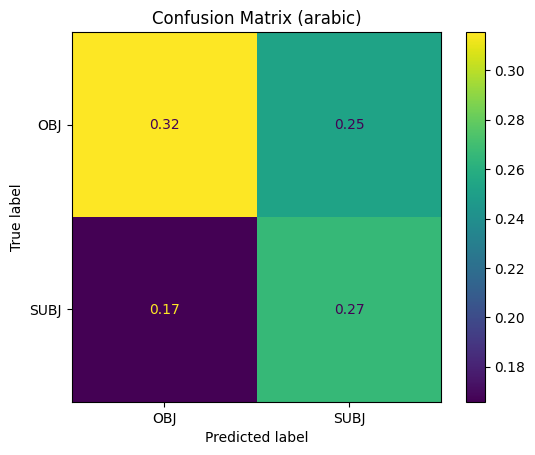

In [30]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

## mDeBERTta v3 base (Bulgarian)

In [31]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


20942

In [32]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [33]:
language = 'bulgarian'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/729 [00:00<?, ? examples/s]

Map:   0%|          | 0/314 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [34]:
model = detector.get_model(
    model_card=f"MatteoFasulo/mdeberta-v3-base-subjectivity-{language}", 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [35]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [36]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights
)

Saved predictions into file: results/dev_bulgarian_predicted.tsv


Saved predictions into file: results/test_bulgarian_predicted.tsv
{'macro_F1': 0.7681505034446212, 'macro_P': 0.7736001617141701, 'macro_R': 0.765374812103784, 'SUBJ_F1': 0.7254901960784315, 'SUBJ_P': 0.7628865979381443, 'SUBJ_R': 0.6915887850467289, 'accuracy': 0.776}


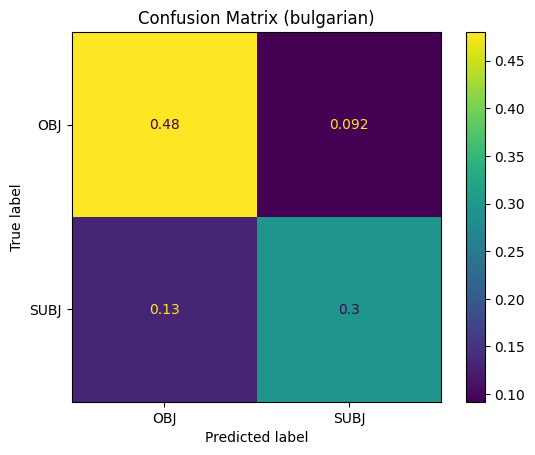

In [37]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

## mDeBERTa-base (English)

In [38]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5413

In [39]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [40]:
language = 'english'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

In [41]:
model = detector.get_model(
    model_card=f"MatteoFasulo/mdeberta-v3-base-subjectivity-{language}", 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [42]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [43]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights
)

Saved predictions into file: results/dev_english_predicted.tsv


Saved predictions into file: results/test_english_predicted.tsv
{'macro_F1': 0.6649712583140217, 'macro_P': 0.6785538867202647, 'macro_R': 0.6563943483380129, 'SUBJ_F1': 0.484304932735426, 'SUBJ_P': 0.5346534653465347, 'SUBJ_R': 0.4426229508196721, 'accuracy': 0.762396694214876}


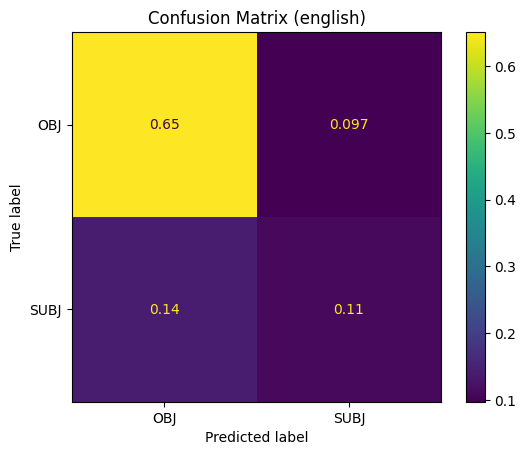

In [44]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

## ModernBERT-base (English)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5311

In [ ]:
model_card = "answerdotai/ModernBERT-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [ ]:
language = 'english'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

In [ ]:
model = detector.get_model(
    model_card=f"MatteoFasulo/ModernBERT-base-subjectivity-{language}", 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/598M [00:00<?, ?B/s]

In [ ]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"ModernBERT-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [ ]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights,
)

Saved predictions into file: results/dev_english_modern_predicted.tsv


Saved predictions into file: results/test_english_modern_predicted.tsv
{'macro_F1': 0.692169742466896, 'macro_P': 0.6829268292682926, 'macro_R': 0.7119373245177067, 'SUBJ_F1': 0.5611510791366907, 'SUBJ_P': 0.5, 'SUBJ_R': 0.639344262295082, 'accuracy': 0.7479338842975206}


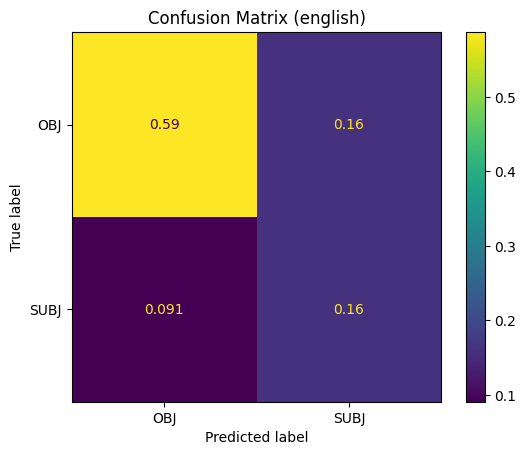

In [ ]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_modern_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_modern_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

## Llama-3.2-1B (English)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5133

In [ ]:
model_card = "meta-llama/Llama-3.2-1B" # meta-llama/Meta-Llama-3-8B
language = 'english'

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = False, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_card, add_prefix_space=True)
model = AutoModelForSequenceClassification.from_pretrained(
    f"MatteoFasulo/Llama-3.2-1B-subjectivity-{language}",
    #quantization_config=quantization_config,
    num_labels=2,
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

In [ ]:
model = prepare_model_for_kbit_training(model)
model

In [ ]:
model = get_peft_model(model, lora_config)
model

In [ ]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

In [ ]:
epochs = 6
batch_size = 16
lr = 1e-4
weight_decay = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

In [ ]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"Llama-3.2-1B-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [ ]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

Saved predictions into file: results/dev_english_llama_predicted.tsv


Saved predictions into file: results/test_english_llama_predicted.tsv
{'macro_F1': 0.6375322645144872, 'macro_P': 0.7426753611375265, 'macro_R': 0.6213431754370076, 'SUBJ_F1': 0.4046242774566474, 'SUBJ_P': 0.6862745098039216, 'SUBJ_R': 0.28688524590163933, 'accuracy': 0.7871900826446281}


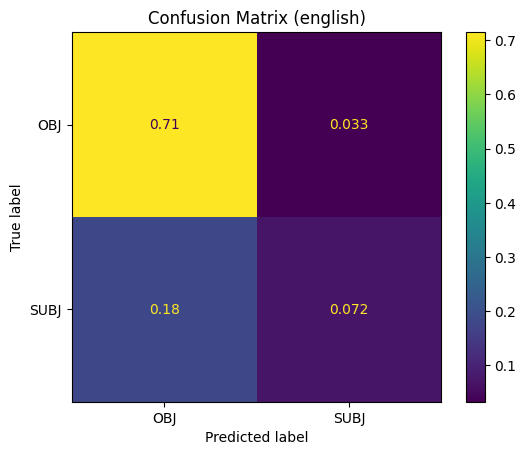

In [ ]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_llama_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_llama_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"llama3.2-1B-{language}-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

## mDeBERTta v3 base (German)

In [45]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5249

In [46]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [47]:
language = 'german'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/491 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

In [48]:
model = detector.get_model(
    model_card=f"MatteoFasulo/mdeberta-v3-base-subjectivity-{language}", 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [49]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [50]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights
)

Saved predictions into file: results/dev_german_predicted.tsv


Saved predictions into file: results/test_german_predicted.tsv
{'macro_F1': 0.8217978848413632, 'macro_P': 0.8169956055816823, 'macro_R': 0.8278123255999362, 'SUBJ_F1': 0.7652173913043478, 'SUBJ_P': 0.7394957983193278, 'SUBJ_R': 0.7927927927927928, 'accuracy': 0.8397626112759644}


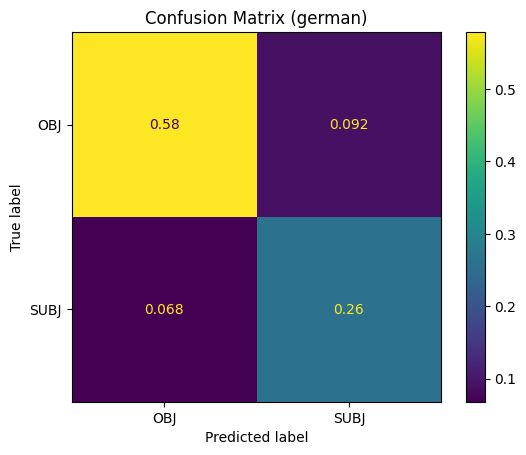

In [51]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

## mDeBERTa-base (italian)

In [52]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5157

In [53]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [54]:
language = 'italian'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/1613 [00:00<?, ? examples/s]

Map:   0%|          | 0/667 [00:00<?, ? examples/s]

Map:   0%|          | 0/513 [00:00<?, ? examples/s]

In [55]:
model = detector.get_model(
    model_card=f"MatteoFasulo/mdeberta-v3-base-subjectivity-{language}", 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [56]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [57]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights
)

---

In [ ]:
# Test - Translating Arab to English

with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

model_card = "answerdotai/ModernBERT-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = AutoModelForSequenceClassification.from_pretrained(
    model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

language = 'arabic'

!ct2-transformers-converter --model Helsinki-NLP/opus-mt-ar-en --output_dir opus-mt-ar-en

import ctranslate2
import transformers

translator = ctranslate2.Translator("opus-mt-ar-en", device='cuda')
tokenizer = transformers.AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ar-en")

def translate_text(raw_text):
    source = tokenizer.convert_ids_to_tokens(tokenizer.encode(raw_text))
    results = translator.translate_batch([source])
    target = results[0].hypotheses[0]
    translation = tokenizer.decode(tokenizer.convert_tokens_to_ids(target))
    return translation

detector.all_data[language]['train']['translated_sentence'] = detector.all_data[language]['train']['sentence'].progress_apply(translate_text)

detector.all_data[language]['dev']['translated_sentence'] = detector.all_data[language]['dev']['sentence'].progress_apply(translate_text)

detector.all_data[language]['test']['translated_sentence'] = detector.all_data[language]['test']['sentence'].progress_apply(translate_text)

detector.all_data[language]['train'].to_csv('/kaggle/working/train_ar.csv')
detector.all_data[language]['dev'].to_csv('/kaggle/working/dev_ar.csv')
detector.all_data[language]['test'].to_csv('/kaggle/working/dev_test_ar.csv')

detector.all_data[language]['train'] = pd.read_csv('/kaggle/working/train_ar.csv')
detector.all_data[language]['dev'] = pd.read_csv('/kaggle/working/dev_ar.csv')
detector.all_data[language]['test'] = pd.read_csv('/kaggle/working/dev_test_ar.csv')

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

def tokenize_text(texts):
    return tokenizer(texts['translated_sentence'], padding=True, truncation=True, max_length=256, return_tensors='pt')

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

# Define training args
training_args = TrainingArguments(
    output_dir=f"ModernBERT-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights
)

trainer.train()

best_thr = trainer.compute_best_threshold(dataset=dev_data)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"llama3.2-1B-{language}"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

---

# Monolingual Training with Sentiment Pipeline

In this section we will train the DeBERTa-V3 model on the monolingual setting using the sentiment pipeline. The model will be trained on the training set and validated on the development set. The model will be evaluated on the test set.

The sentiment is added to the input of the model to provide additional information using the sentiment pipeline described before. However, the sentiment information is used only with the CLS token output of the model.

>More advanced techniques could explore the use of sentiment in early stages of the model, but this is out of the scope of this notebook.

## mdeberta-v3-base (arabic + sentiment)

In [46]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5172

In [48]:
language = 'arabic'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

In [49]:
model_card = "microsoft/mdeberta-v3-base"

tokenizer = detector.get_tokenizer(model_card=model_card)

# Load the config
config = DebertaV2Config.from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}",
    num_labels=2,
    id2label={0: 'OBJ', 1: 'SUBJ'},
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions=False,
    output_hidden_states=False
)

# Initialize the custom model
model = CustomModel(config=config, sentiment_dim=3, num_labels=2).from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}"
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
detector.all_data[language]['train'][['positive', 'neutral', 'negative']] = detector.all_data[language]['train'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['dev'][['positive', 'neutral', 'negative']] = detector.all_data[language]['dev'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['test'][['positive', 'neutral', 'negative']] = detector.all_data[language]['test'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

In [50]:
train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/2446 [00:00<?, ? examples/s]

Map:   0%|          | 0/467 [00:00<?, ? examples/s]

Map:   0%|          | 0/748 [00:00<?, ? examples/s]

In [51]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-sentiment-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [52]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

Saved predictions into file: results/dev_arabic_sentiment_predicted.tsv


Saved predictions into file: results/test_arabic_sentiment_predicted.tsv
{'macro_F1': 0.573528649533604, 'macro_P': 0.5846455544863383, 'macro_R': 0.5845820433436533, 'SUBJ_F1': 0.5740987983978638, 'SUBJ_P': 0.5046948356807511, 'SUBJ_R': 0.6656346749226006, 'accuracy': 0.5735294117647058}


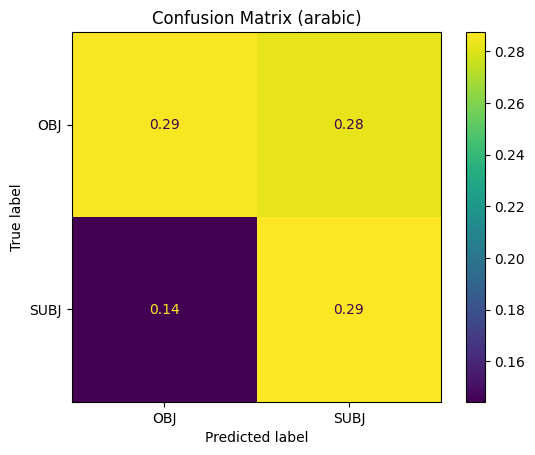

In [53]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_sentiment_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_sentiment_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-sentiment-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

## mdeberta-v3-base (bulgarian + sentiment)

In [54]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5355

In [56]:
language = 'bulgarian'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

In [57]:
model_card = "microsoft/mdeberta-v3-base"

tokenizer = detector.get_tokenizer(model_card=model_card)

# Load the config
config = DebertaV2Config.from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}",
    num_labels=2,
    id2label={0: 'OBJ', 1: 'SUBJ'},
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions=False,
    output_hidden_states=False
)

# Initialize the custom model
model = CustomModel(config=config, sentiment_dim=3, num_labels=2).from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}"
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
detector.all_data[language]['train'][['positive', 'neutral', 'negative']] = detector.all_data[language]['train'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['dev'][['positive', 'neutral', 'negative']] = detector.all_data[language]['dev'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['test'][['positive', 'neutral', 'negative']] = detector.all_data[language]['test'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

Device set to use cuda:0
100%|██████████| 250/250 [00:02<00:00, 124.79it/s]


In [59]:
train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/729 [00:00<?, ? examples/s]

Map:   0%|          | 0/314 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [60]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-sentiment-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [61]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

Saved predictions into file: results/dev_bulgarian_sentiment_predicted.tsv


Saved predictions into file: results/test_bulgarian_sentiment_predicted.tsv
{'macro_F1': 0.7717788210745957, 'macro_P': 0.7712277962131564, 'macro_R': 0.7724331743023332, 'SUBJ_F1': 0.7407407407407407, 'SUBJ_P': 0.7339449541284404, 'SUBJ_R': 0.7476635514018691, 'accuracy': 0.776}


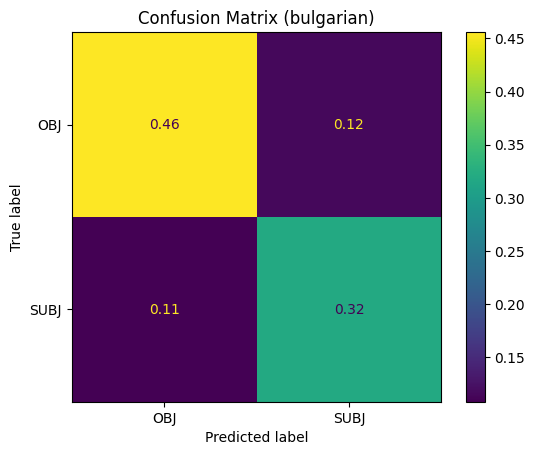

In [62]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_sentiment_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_sentiment_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-sentiment-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

## mdeberta-v3-base (english + sentiment)

In [63]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5349

In [65]:
language = 'english'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

In [66]:
model_card = "microsoft/mdeberta-v3-base"

tokenizer = detector.get_tokenizer(model_card=model_card)

# Load the config
config = DebertaV2Config.from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}",
    num_labels=2,
    id2label={0: 'OBJ', 1: 'SUBJ'},
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions=False,
    output_hidden_states=False
)

# Initialize the custom model
model = CustomModel(config=config, sentiment_dim=3, num_labels=2).from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}"
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
detector.all_data[language]['train'][['positive', 'neutral', 'negative']] = detector.all_data[language]['train'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['dev'][['positive', 'neutral', 'negative']] = detector.all_data[language]['dev'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['test'][['positive', 'neutral', 'negative']] = detector.all_data[language]['test'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

Device set to use cuda:0
100%|██████████| 484/484 [00:03<00:00, 124.31it/s]


In [68]:
train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

In [69]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-sentiment-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [70]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

Saved predictions into file: results/dev_english_sentiment_predicted.tsv


Saved predictions into file: results/test_english_sentiment_predicted.tsv
{'macro_F1': 0.7036481068162515, 'macro_P': 0.7610920945395273, 'macro_R': 0.6813467982972556, 'SUBJ_F1': 0.5279187817258882, 'SUBJ_P': 0.6933333333333334, 'SUBJ_R': 0.4262295081967213, 'accuracy': 0.8078512396694215}


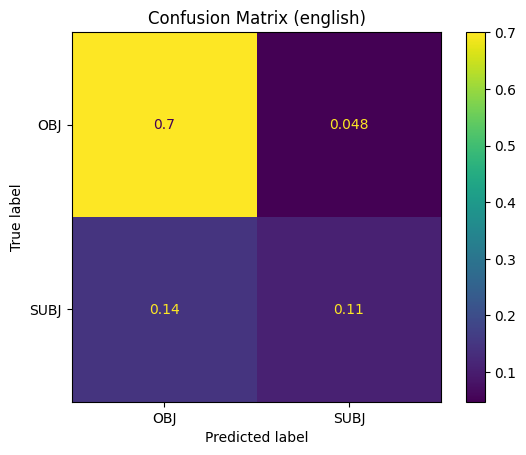

In [71]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_sentiment_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_sentiment_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-sentiment-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

## ModernBERT (english + sentiment)

In [159]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5372

In [160]:
class CustomModernBertModel(ModernBertPreTrainedModel):
    config_class = ModernBertConfig

    def __init__(self, config, sentiment_dim=3, num_labels=2, *args, **kwargs):
        super().__init__(config, *args, **kwargs)

        self.config = config
        self.model = ModernBertModel(config)
        self.head = torch.nn.Sequential(
            nn.Linear(config.hidden_size + sentiment_dim, config.hidden_size + sentiment_dim, config.classifier_bias),
            GELUActivation(),
            nn.LayerNorm(config.hidden_size + sentiment_dim, eps=config.norm_eps, bias=config.norm_bias)
        )
            
        self.dropout = nn.Dropout(0.1)

        self.classifier = nn.Linear(config.hidden_size + sentiment_dim, num_labels)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(self, input_ids, positive, neutral, negative, attention_mask=None, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

        last_hidden_state = outputs[0]

        if self.config.classifier_pooling == "cls":
            last_hidden_state = last_hidden_state[:, 0]
        elif self.config.classifier_pooling == "mean":
            last_hidden_state = (last_hidden_state * attention_mask.unsqueeze(-1)).sum(dim=1) / attention_mask.sum(
                dim=1, keepdim=True
            )
        
        # Sentiment features as a single tensor
        sentiment_features = torch.stack((positive, neutral, negative), dim=1)  # Shape: (batch_size, 3)
        
        # Combine output embedding with sentiment features
        combined_features = torch.cat((last_hidden_state, sentiment_features), dim=1)

        pooled_output = self.head(combined_features)
        
        # Classification head
        logits = self.classifier(self.dropout(pooled_output))
        
        return {'logits': logits}

In [161]:
language = 'english'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

In [162]:
model_card = "answerdotai/ModernBERT-base"

tokenizer = detector.get_tokenizer(model_card=model_card)

# Load the config
config = ModernBertConfig.from_pretrained(
    model_card,
    num_labels=2,
    id2label={0: 'OBJ', 1: 'SUBJ'},
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions=False,
    output_hidden_states=False,
    classifier_pooling='mean'
)

# Initialize the custom model
model = CustomModernBertModel(config=config, sentiment_dim=3, num_labels=2)

In [163]:
model

CustomModernBertModel(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      )
      (1-21)

In [87]:
detector.all_data[language]['train'][['positive', 'neutral', 'negative']] = detector.all_data[language]['train'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['dev'][['positive', 'neutral', 'negative']] = detector.all_data[language]['dev'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['test'][['positive', 'neutral', 'negative']] = detector.all_data[language]['test'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

100%|██████████| 484/484 [00:03<00:00, 122.21it/s]


In [164]:
train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/830 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

In [165]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"ModernBERT-base-subjectivity-sentiment-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [166]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

In [167]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.788585,0.515848,0.552997,0.543131,0.420485,0.595420,0.325000,0.534632
2,No log,0.682989,0.577699,0.587185,0.581813,0.638941,0.584775,0.704167,0.586580
3,No log,0.911566,0.540330,0.572359,0.561712,0.460733,0.619718,0.366667,0.554113
4,No log,0.899891,0.557452,0.567572,0.564752,0.520095,0.601093,0.458333,0.560606
5,No log,1.020627,0.553662,0.577237,0.569200,0.489899,0.621795,0.404167,0.562771
6,No log,1.006108,0.559133,0.575610,0.570270,0.508557,0.615385,0.433333,0.564935


TrainOutput(global_step=312, training_loss=0.3468782962896885, metrics={'train_runtime': 139.5181, 'train_samples_per_second': 35.694, 'train_steps_per_second': 2.236, 'total_flos': 473979321747360.0, 'train_loss': 0.3468782962896885, 'epoch': 6.0})

Saved predictions into file: results/dev_english_sentiment_predicted.tsv


Saved predictions into file: results/test_english_sentiment_predicted.tsv
{'macro_F1': 0.5696138211382115, 'macro_P': 0.5741138560687433, 'macro_R': 0.5937415089212934, 'SUBJ_F1': 0.41666666666666674, 'SUBJ_P': 0.34210526315789475, 'SUBJ_R': 0.5327868852459017, 'accuracy': 0.6239669421487604}


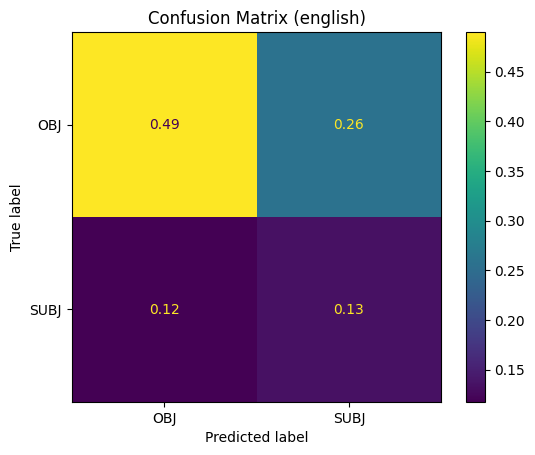

In [168]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_sentiment_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_sentiment_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-sentiment-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

## mdeberta-v3-base (german + sentiment)

In [81]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5288

In [83]:
language = 'german'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

In [84]:
model_card = "microsoft/mdeberta-v3-base"

tokenizer = detector.get_tokenizer(model_card=model_card)

# Load the config
config = DebertaV2Config.from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}",
    num_labels=2,
    id2label={0: 'OBJ', 1: 'SUBJ'},
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions=False,
    output_hidden_states=False
)

# Initialize the custom model
model = CustomModel(config=config, sentiment_dim=3, num_labels=2).from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}"
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
detector.all_data[language]['train'][['positive', 'neutral', 'negative']] = detector.all_data[language]['train'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['dev'][['positive', 'neutral', 'negative']] = detector.all_data[language]['dev'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['test'][['positive', 'neutral', 'negative']] = detector.all_data[language]['test'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

Device set to use cuda:0
100%|██████████| 337/337 [00:02<00:00, 124.02it/s]


In [86]:
train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/491 [00:00<?, ? examples/s]

Map:   0%|          | 0/337 [00:00<?, ? examples/s]

In [87]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-sentiment-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [88]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

Saved predictions into file: results/dev_german_sentiment_predicted.tsv


Saved predictions into file: results/test_german_sentiment_predicted.tsv
{'macro_F1': 0.829107505070994, 'macro_P': 0.8232897153351699, 'macro_R': 0.8368213346089453, 'SUBJ_F1': 0.7758620689655173, 'SUBJ_P': 0.743801652892562, 'SUBJ_R': 0.8108108108108109, 'accuracy': 0.8456973293768546}


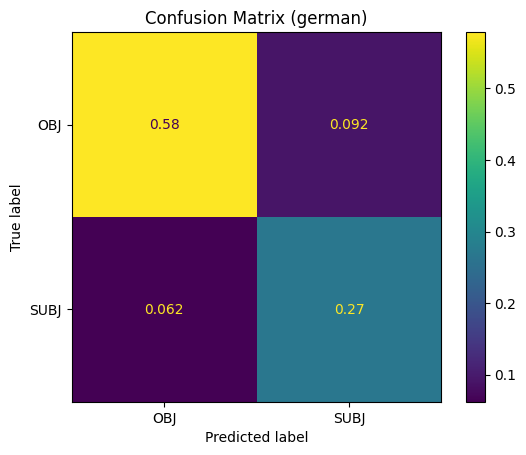

In [89]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_sentiment_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_sentiment_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-sentiment-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

## mdeberta-v3-base (italian + sentiment)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

Model deleted!


5297

In [ ]:
language = 'italian'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

In [ ]:
model_card = "microsoft/mdeberta-v3-base"

tokenizer = detector.get_tokenizer(model_card=model_card)

# Load the config
config = DebertaV2Config.from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}",
    num_labels=2,
    id2label={0: 'OBJ', 1: 'SUBJ'},
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions=False,
    output_hidden_states=False
)

# Initialize the custom model
model = CustomModel(config=config, sentiment_dim=3, num_labels=2).from_pretrained(
    f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}"
)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
detector.all_data[language]['train'][['positive', 'neutral', 'negative']] = detector.all_data[language]['train'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['dev'][['positive', 'neutral', 'negative']] = detector.all_data[language]['dev'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['test'][['positive', 'neutral', 'negative']] = detector.all_data[language]['test'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

Device set to use cuda:0
100%|██████████| 513/513 [00:04<00:00, 123.48it/s]


In [ ]:
train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/1613 [00:00<?, ? examples/s]

Map:   0%|          | 0/667 [00:00<?, ? examples/s]

Map:   0%|          | 0/513 [00:00<?, ? examples/s]

In [ ]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-sentiment-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [ ]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

Saved predictions into file: results/dev_italian_sentiment_predicted.tsv


Saved predictions into file: results/test_italian_sentiment_predicted.tsv
{'macro_F1': 0.7769408794445614, 'macro_P': 0.7676788610560461, 'macro_R': 0.7897000312061164, 'SUBJ_F1': 0.6804123711340205, 'SUBJ_P': 0.6387096774193548, 'SUBJ_R': 0.7279411764705882, 'accuracy': 0.8187134502923976}


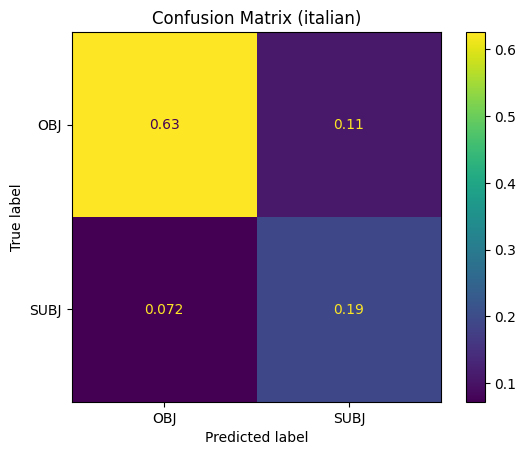

In [ ]:
# Decision threshold calibration on dev set
best_thr = trainer.compute_best_threshold(dataset=dev_data)
# Predictions on dev set (with best threshold on dev set)
pred_info = trainer.predict(dataset=dev_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save dev set predictions
save_predictions(dev_data, predictions, filename = f"dev_{language}_sentiment_predicted.tsv")

# Predictions on test set (with best threshold on dev set)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

# Save test set predictions
save_predictions(test_data, predictions, filename = f"test_{language}_sentiment_predicted.tsv")

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-sentiment-thr"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

---

In [99]:
pd.DataFrame(results).T.sort_values(by='macro_F1', ascending=False).round(4)

,macro_F1,macro_P,macro_R,SUBJ_F1,SUBJ_P,SUBJ_R,accuracy
german-sentiment-thr,0.8291,0.8233,0.8368,0.7759,0.7438,0.8108,0.8457
italian-sentiment-thr,0.7769,0.7677,0.7897,0.6804,0.6387,0.7279,0.8187
bulgarian-sentiment-thr,0.7718,0.7712,0.7724,0.7407,0.7339,0.7477,0.7760
english-sentiment-thr,0.7036,0.7611,0.6813,0.5279,0.6933,0.4262,0.8079
multilingual-sentiment-thr,0.6798,0.7386,0.6691,0.5332,0.7247,0.4218,0.7470
arabic-sentiment-thr,0.5735,0.5846,0.5846,0.5741,0.5047,0.6656,0.5735


In [76]:
predictions_dict['true_labels'] = labels
predictions_dict['sentence'] = test_data['sentence']
predictions_dict['sentence_id'] = test_data['sentence_id']
predictions_dict['positive'] = test_data['positive']
predictions_dict['neutral'] = test_data['neutral']
predictions_dict['negative'] = test_data['negative']

In [77]:
predictions_df = pd.DataFrame(predictions_dict)
predictions_df.head()

,english-sentiment-thr,english-thr,english-modern-bert-thr,true_labels,sentence,sentence_id,positive,neutral,negative
0,0,0,0,0,Blanco established himself earlier in his care...,44f33601-157a-42ce-aa9f-0f7d305501f2,0.802878,0.178354,0.018768
1,0,0,0,0,RULE 13: ARTIFICIAL INTELLIGENCE Not only thi...,6f9e0f53-f76c-432f-bbea-b78400d600b8,0.508778,0.389381,0.101840
2,0,0,0,0,The valuation is required by law and the figur...,61f93bdc-4c3e-4963-926c-0bbf139b44b9,0.849510,0.093090,0.057400
3,1,1,0,1,A sip can really hit the spot after a long bik...,902148ec-dda3-4736-b318-0f20c63a1cf3,0.220061,0.736456,0.043484
4,0,0,0,0,"""Lobster!""""""",065b1996-4b40-4c74-9f62-afb44f69834e,0.444932,0.295773,0.259295


In [78]:
predictions_df.to_csv('predictions_to_be_compared.csv', index=False, encoding='UTF-8')

In [79]:
# correct guess but sentiment provides better understanding
predictions_df[(predictions_df['english-sentiment-thr'] == predictions_df['true_labels']) & 
                (predictions_df['english-sentiment-thr'] != predictions_df['english-thr'])]

,english-sentiment-thr,english-thr,english-modern-bert-thr,true_labels,sentence,sentence_id,positive,neutral,negative
6,0,1,1,0,Googled how to cook a good lobster and I read ...,d5429c1d-802b-4427-8ffa-88ac62091a62,0.128520,0.024822,0.846658
48,0,1,1,0,This is why the more Osborne slashed public sp...,f77261bb-91b1-4f85-809c-8a588bcf1ab7,0.410512,0.116610,0.472878
49,0,1,1,0,"When your credit card is “maxed out”, you do i...",2510c90d-872b-44f3-9329-7e614f6ba821,0.268093,0.042711,0.689196
50,0,1,1,0,This was inaccurate.,fd834368-aa38-4dd6-aecd-ad2d6ac00ad0,0.078637,0.020564,0.900799
55,0,1,0,0,"""I know you was heartbroken lol.""""""",4e021920-81a3-44e0-97e7-e5fc7d0acb46,0.361328,0.119520,0.519152
58,0,1,0,0,I scribbled down what I saw and what I felt an...,b256f52b-e2ce-49f5-b3be-8b2e48e99000,0.681925,0.182852,0.135223
61,0,1,0,0,"""But one person who knows exactly what's that ...",c8840daf-2871-4d51-9c40-53d22cd8a8f8,0.070693,0.010807,0.918500
68,0,1,0,0,"""""""I'm not really a gambler - it was a $10k (£...",03802121-73ba-427a-8a60-1a5d3bc64dfe,0.565224,0.120331,0.314445
69,0,1,0,0,When it was an Emma and Dex day I felt good ab...,3934802e-66b0-4501-9ff2-2a4ce3b19371,0.230351,0.737375,0.032274
100,0,1,0,0,Bring it out done.',ef352be8-43ca-4627-bc90-9477a3e0e322,0.618892,0.335233,0.045875
